In [2]:
import os
os.chdir('DLFromScratch2')

# 추론 기반 기법과 신경망

## 통계 기반 기법의 문제점

통계 기반 기법
- 주변 단어의 빈도를 기초로 단어 표현
- 동시 발생 행렬 구축, 그 행렬에 SVD 적용해 밀집벡터 얻음
- 문제: 대규모 말뭉치 처리 불가
    
추론 기반 기법
- 통계 기반 기법이 1회의 처리로 단어의 분산 표현을 얻는 반면, 신경망 이용의 경우는 미니배치로 학습
- 한번에 소량(미니 배치)의 샘플씩 반복해서 학습하며 가중치를 갱신
- 통계기반은 한번에 데이터 처리(배치 학습), 추론기반은 순차적 학습(미니배치 학습)


## 추론 기반 기법 개요

- 추론: 주변 단어가 주어졌을 때, 중심에 해당하는 단어가 무엇인지를 추측하는 작업
- 모델은 맥락 정보를 입력받아 각 단어의 출현 확률을 출력함

## 신경망에서의 단어 처리

- 단어의 고정된 길이의 벡터 변환을 위해 원핫 벡터로 표현
- 입력층의 각 뉴런이 하나의 단어에 대응됨

In [3]:
import numpy as np

c = np.array([[1,0,0,0,0,0,0]])
W = np.random.randn(7,3)
h = np.matmul(c,W)
print(h)

[[ 0.44339719 -2.30055744  0.82188342]]


In [4]:
W # W에서 해당하는 위치의 행벡터가 출력됨

array([[ 0.44339719, -2.30055744,  0.82188342],
       [-0.38691486,  0.75179655, -0.22319306],
       [ 0.31772256,  2.09195278, -0.87054919],
       [ 0.6275137 ,  0.1755189 , -0.10440116],
       [ 0.72583285, -1.03972774,  0.97983999],
       [-0.1242409 ,  1.35719337,  1.67443467],
       [-0.02860714,  2.44962199,  0.37887967]])

In [5]:
import sys
sys.path.append('..')
from common.layers import MatMul

c = np.array([[1,0,0,0,0,0,0]])
W = np.random.randn(7,3)
layer = MatMul(c)
print(h)

[[ 0.44339719 -2.30055744  0.82188342]]


# 단순한 word2vec

## CBOW 모델의 추론처리

- 맥락으로부터 타깃을 추측하는 신경망
- 앞, 뒤의 주변단어로 부터 중심 단어를 추론하는 모델 구조 예시
    - 2개의 입력층
    - 은닉층의 뉴런은 입력 층의 완전연결계층에 의해 변환된 값이 됨
    - 그런데 입력 층이 여러개라면 전체를 평균냄
    - 7개의 출력층: 각 뉴런이 단어의 점수를 의미하고, 소프트맥스 함수를 통해 확률 값으로 해석됨
    - 입력층에서 은닉층으로의 가중치 변환: Win에 의해 이루어짐. 이것이 단어 분산 표현이 됨.
    - 학습 진행 과정에서 맥락에서 등장하는 단어를 잘 추측하는 방향으로 표현이 갱신됨

- 인코딩
    - 은닉층의 뉴런 수는 입력층의 뉴런 수보다 작아야 함: 은닉층에 단어 예측에 필요한 정보를 간결하게 담도록 함
    - 은닉층의 정보는 우리가 이해할 수 없는 코드
    
- 디코딩: 인코딩된 정보를 인간이 이해할 수 있는 표현으로 복원
    
- 계층 관점에서의 구성
     - 가장 앞단에 2개의 MatMul 계층
     - 두 계층의 출력에 0.5 곱해 더해 평균으로
     - 은닉층 뉴런에 또 다른 MatMul 계층 적용으로 score 도출


In [7]:
# 샘플 맥락 데이터
c0 = np.array([1,0,0,0,0,0,0])
c1 = np.array([0,0,1,0,0,0,0])

# 가중치 초기화
W_in = np.random.randn(7,3)
W_out = np.random.randn(3,7)

# 계층 생성
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 순전파
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)

print(s)



[-0.61619978 -0.14520004  1.59015975  0.1270844   0.42397454 -0.75034746
 -1.32181235]


## CBOW 모델의 학습

- 다중 클래스 분류 수행 신경망
- 소프트맥스 함수를 이용해 점수를 확률로 변환
- 확률과 정답 레이블로 교차 엔트로피 오차 도출
- 해당 값을 손실로 사용해 학습을 진행
- 구현은 sormax with loss로 할 것

## word2vec의 가중치와 분산 표현

- 입력 측 가중치 행렬: 각 행이 단어의 분산 표현에 해당함
- 출력 측 가중치 행렬: 각 열이 단어의 분산 표현에 해당함
- 분산 표현의 선택지: 입력측, 출력측 혹은 둘 다
- 일반적으로는 입력측의 가중치만을 사용

# 학습 데이터 준비

## 맥락과 타깃

- 맥락을 입력으로, 타깃이 정답 레이블이 됨
- 말뭉치 텍스트를 단어 id로 변환하고, 맥락 타깃 변환 수행

In [8]:
from common.util import preprocess
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)

print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [9]:
def create_contexts_target(corpus, window_size = 1):
    target = corpus[window_size:-window_size]
    contexts = []
    
    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size +1):
            if t==0:
                continue
            cs.append(copus[idx + t])
        contexts.append(cs)
    return np.array(contexts), np.array(target)

## 원핫 표현으로 변환

In [10]:
from common.util import preprocess, create_contexts_target, convert_one_hot
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size = 1)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

# CBOW 모델 구현

In [17]:
# chap03/simple_cbow.py
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss


class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')
        
        # 레이어 생성
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs1 = W_in
        self.word_vecs2 = W_out.T
        
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss
    
    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

# 학습 코드 구현

In [19]:
import sys
sys.path.append('..')
from common.trainer import Trainer
from common.optimizer import Adam
# from simple_cbow import SimpleCBOW
from common.util import preprocess, create_contexts_target, convert_one_hot


window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
# cbow 학습 데이터셋 생성
contexts, target = create_contexts_target(corpus, window_size)
# Input에 맞는 one-hot 표현 변환
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

# 모델 초기화
model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

| 에폭 244 |  반복 1 / 2 | 시간 0[s] | 손실 1.18
| 에폭 245 |  반복 1 / 2 | 시간 0[s] | 손실 1.02
| 에폭 246 |  반복 1 / 2 | 시간 0[s] | 손실 1.02
| 에폭 247 |  반복 1 / 2 | 시간 0[s] | 손실 1.17
| 에폭 248 |  반복 1 / 2 | 시간 0[s] | 손실 1.15
| 에폭 249 |  반복 1 / 2 | 시간 0[s] | 손실 1.02
| 에폭 250 |  반복 1 / 2 | 시간 0[s] | 손실 1.08
| 에폭 251 |  반복 1 / 2 | 시간 0[s] | 손실 1.14
| 에폭 252 |  반복 1 / 2 | 시간 0[s] | 손실 1.10
| 에폭 253 |  반복 1 / 2 | 시간 0[s] | 손실 1.05
| 에폭 254 |  반복 1 / 2 | 시간 0[s] | 손실 0.93
| 에폭 255 |  반복 1 / 2 | 시간 0[s] | 손실 1.15
| 에폭 256 |  반복 1 / 2 | 시간 0[s] | 손실 0.99
| 에폭 257 |  반복 1 / 2 | 시간 0[s] | 손실 1.14
| 에폭 258 |  반복 1 / 2 | 시간 0[s] | 손실 0.98
| 에폭 259 |  반복 1 / 2 | 시간 0[s] | 손실 1.14
| 에폭 260 |  반복 1 / 2 | 시간 0[s] | 손실 1.06
| 에폭 261 |  반복 1 / 2 | 시간 0[s] | 손실 1.12
| 에폭 262 |  반복 1 / 2 | 시간 0[s] | 손실 0.96
| 에폭 263 |  반복 1 / 2 | 시간 0[s] | 손실 1.09
| 에폭 264 |  반복 1 / 2 | 시간 0[s] | 손실 1.11
| 에폭 265 |  반복 1 / 2 | 시간 0[s] | 손실 0.94
| 에폭 266 |  반복 1 / 2 | 시간 0[s] | 손실 1.06
| 에폭 267 |  반복 1 / 2 | 시간 0[s] | 손실 1.04
| 에폭 268 |  반복 1

| 에폭 665 |  반복 1 / 2 | 시간 0[s] | 손실 0.47
| 에폭 666 |  반복 1 / 2 | 시간 0[s] | 손실 0.54
| 에폭 667 |  반복 1 / 2 | 시간 0[s] | 손실 0.73
| 에폭 668 |  반복 1 / 2 | 시간 0[s] | 손실 0.37
| 에폭 669 |  반복 1 / 2 | 시간 0[s] | 손실 0.65
| 에폭 670 |  반복 1 / 2 | 시간 0[s] | 손실 0.44
| 에폭 671 |  반복 1 / 2 | 시간 0[s] | 손실 0.56
| 에폭 672 |  반복 1 / 2 | 시간 0[s] | 손실 0.62
| 에폭 673 |  반복 1 / 2 | 시간 0[s] | 손실 0.47
| 에폭 674 |  반복 1 / 2 | 시간 0[s] | 손실 0.62
| 에폭 675 |  반복 1 / 2 | 시간 0[s] | 손실 0.47
| 에폭 676 |  반복 1 / 2 | 시간 0[s] | 손실 0.54
| 에폭 677 |  반복 1 / 2 | 시간 0[s] | 손실 0.61
| 에폭 678 |  반복 1 / 2 | 시간 0[s] | 손실 0.47
| 에폭 679 |  반복 1 / 2 | 시간 0[s] | 손실 0.54
| 에폭 680 |  반복 1 / 2 | 시간 0[s] | 손실 0.63
| 에폭 681 |  반복 1 / 2 | 시간 0[s] | 손실 0.45
| 에폭 682 |  반복 1 / 2 | 시간 0[s] | 손실 0.45
| 에폭 683 |  반복 1 / 2 | 시간 0[s] | 손실 0.70
| 에폭 684 |  반복 1 / 2 | 시간 0[s] | 손실 0.54
| 에폭 685 |  반복 1 / 2 | 시간 0[s] | 손실 0.46
| 에폭 686 |  반복 1 / 2 | 시간 0[s] | 손실 0.60
| 에폭 687 |  반복 1 / 2 | 시간 0[s] | 손실 0.46
| 에폭 688 |  반복 1 / 2 | 시간 0[s] | 손실 0.60
| 에폭 689 |  반복 1

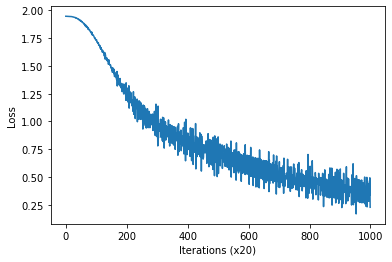

In [20]:
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [22]:
word_vecs = model.word_vecs1
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

you [ 0.39698964  0.91498166 -1.6708705   0.9238411   1.0304754 ]
say [-1.2075901  -1.1077158  -0.39645377 -1.1170006  -1.1491385 ]
goodbye [1.2756077  1.1054441  0.26569432 1.1021214  0.948238  ]
and [-0.85259134 -0.712606   -1.8291335  -0.73379946 -0.7567558 ]
i [1.2677215 1.0931795 0.2700234 1.1106517 0.9611387]
hello [ 0.3999709  0.9147157 -1.6746805  0.9288991  1.0255922]
. [-1.2177138 -1.2249241  1.6352813 -1.1852229 -1.1875747]


# word2vec 보충

## CBOW 모델과 확률
CBOW의 모델링
- t-1, t+1이 주어졌을 때 wi가 일어날 확률 모델링
- 손실함수는 음의 로그 가능도로 볼 수 있음


## skip-gram 모델
- 중앙 단어(타깃)으로부터 주변의 여러 단어를 추측
- t가 주어졌을 때 t-1, t+1이 동시에 일어날 확률을 모델링

- skip-gram의 손실함수는 각 맥락에서 구한 손실의 총 합
- CBOW는 타깃 하나의 손실을 구함
- skip-gram 모델의 단어 표현이 더 좋지만, 학습 속도 면에서는 CBOW가 더 빠름

## 통계 기반 vs 추론 기반
- 새로운 단어가 생겨 단어 분산 표현 갱신 필요 경우
    - 통계기반: 다시 동시발생 행렬 만들고 svd해야 함
    - 추론기반: 매개변수를 다시 학습할 수 있음
- 분산 표현
    - 통계 기반: 단어의 유사성이 인코딩 됨
    - 추론 기반: 유사성은 물론, 단어 사이의 패턴까지 파악됨
- 두 세계는 연결되어 있음
    - skip-gram, 네거티브 샘플링 이용한 모델은 동시발생 행렬에 특수한 행렬분해 적용한 것과 같음
    - GloVe: 말뭉치 전체의 통계 정보를 손실 함수에 도입해 미니배치 학습을 하는 것